# Tile Completion Metric

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from pathlib import Path

In [3]:
import collections

In [4]:
import yaml

In [5]:
import fitsio

In [6]:
import scipy.signal

In [7]:
import astropy.units as u

In [8]:
import skysim.eso

In [9]:
import specsim.fastfiberacceptance

In [10]:
import desisurvey.tiles

In [11]:
import extinction

In [12]:
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

The metric $\langle$zSNR$^2\rangle$ for a target class $C$ is defined in [DESI-4723](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=4723) as:
$$
\nu_C^2(t) = \sum_{k=\text{b,r,z}} \sum_\lambda \frac{
t^2 T_\text{target}^2 \langle \delta F^2\rangle}
{\sigma^2_\text{read} N_\text{pix} + t T_\text{sky} F_\text{sky}} \;,
$$
where:
 - $t$ is the exposure time in seconds,
 - $\langle \delta F^2\rangle$ is the ensemble average of $\left(F_i - \tilde{F}_i\right)^2$ over targets $i$ in the class, for noiseless target spectrum $F_i$ and its 100A median filtered $\tilde{F}_i$,
 - $F_\text{sky}$ is the assumed sky spectrum.
 - $T_\text{target}$ converts the target (signal) spectrum into detected electrons per second,
 - $T_\text{sky}$ converts the sky (background) spectrum into detected electrons per second.

For the purposes of the API, we combine the instrumental variance per wavelength bin (assuming negligible dark current):
$$
\sigma^2 \equiv \sigma^2_\text{read} N_\text{pix}
$$
and decompose the signal conversion factor into
$$
T_\text{target} = f_{\text{dust},\lambda} \,f_{\text{atm},\lambda}\, A_{C,\lambda} T_{k,\lambda}
$$
where:
 - $f_\text{dust}$ is the extinction due to galactic dust which depends on the tile (ra,dec),
 - $f_\text{atm}$ is the extinction due to the atmosphere which depends on observing conditions (ETC),
 - $A$ is the fiber acceptance fraction, which depends on the target class and observing conditions (ETC),
 - $T$ is the remaining system throughput, which depends on the camera and is the same for signal and sky.

If we normalize $S \equiv F_\text{sky}$ to the detected sky flux over a nominal fiber area, then
$$
T_\text{sky} = T_{k,\lambda}
$$
and we can write (with explicit indices for the target class $C$, camera $k$ and wavelength $\lambda$):
$$
\nu_C^2(t) = \sum_{k=\text{b,r,z}} \sum_\lambda \frac{
t^2 f^2_{\text{dust},\lambda} \,f^2_{\text{atm},\lambda}\,
A_{C,\lambda}^2 T_{k,\lambda}^2 \langle \delta F^2\rangle_{C,\lambda}}
{\sigma^2_{k,\lambda} + t T_{k,\lambda} S_\lambda}
= t^2 \sum_\lambda f^2_{\text{dust},\lambda} \,f^2_{\text{atm},\lambda}\,
A_{C,\lambda}^2 \langle \delta F^2\rangle_{C,\lambda}
\sum_{k=\text{b,r,z}} \frac{T_{k,\lambda}^2}{\sigma^2_{k,\lambda} + t T_{k,\lambda} S_\lambda} \; .
$$

## Take 2

$$
\nu^2_{C,N} =
\sum_\lambda
\omega_{C\lambda}
D_\lambda^2
\sum_{i=1}^N [\Delta t_i E_{\lambda,i} A_{C \lambda,i}]^2\,\cdot
\sum_{k=b,r,z}
\frac{T_{k\lambda}^2}{\sigma_{k\lambda}^2 + T_{k\lambda} \sum_{i=1}^N \Delta t_i S_{\lambda,i}}
$$

| Symbol  | Code | Unit      | Description |
| :------ | :--: | :-------: | :---------- |
| $i$     | `i`  |           | Time slice index |
| $j$     | `j`  |           | Wavelength bin index corresponding to 3550-9850 A in 1A steps |
| $k$     | `k`  |           | Camera index b=0, r=1, z=2 |
| $\Delta t_i$|    | sec     | Duration of time slice i |
| $X_i$   | `X[i]`|          | Airmass during time slice i |
| $\lambda_j$| `wlen[j]`| Angstrom | Central wavelength of bin j |
| $f_{ijk}$|      | elec      | Detected signal during time slice i in bin j of camera k |
| $\sigma_{ijk}$| | elec      | RMS uncertainty on $f_{ijk}$ |
| $N_{jk}$| `N[j,k]`| elec   | Read noise of bin j of camera k |
| $T_{jk}$| `T[j,k]`| elec/phot | Instrument throughput of bin j of camera k excluding fiberloss |
| $S_{ij}$| `S[i,j]`| phot/sec | Rate of sky photons entering a typical fiber etendue in bin j at time i |
| $D_j$   | `D[j]`  |        | Galactic dust extinction factor in bin j (depends on target RA,DEC) |
| $E_{ij}$| `E[i,j]`|        | Atmospheric zenith extinction coefficient in bin j at time i |
| $A_{ij}$| `A[i,j]`|        | Fiber acceptance fraction in bin j at time i (depends on atm PSF, target profile, fiber offsets) |
| $F_j$   |         | phot/sec | Rate of target photons incident on the primary mirror in bin j |
| $\nu^2_{ijk}$| `snr2[i,j,k]`| | Signal to noise ratio squared accumulated in bin j of camera k during time slice i |

## Overview

The probability of obtaining a successful redshift for a target improves when it is observed  at a higher signal to noise ratio (SNR).  Therefore, the ETC uses a suitably defined SNR as its metric for estimating exposure times.

The signal to noise at time slice $i$ in a single wavelength bin $j$ of camera $k$ is unambiguosly defined as:
$$
\nu_{ijk} \equiv \frac{f_{ijk}}{\sigma_{ijk}}
$$
where $f_{ijk}$ is the (true mean) detected signal in electrons from the target and $\sigma_{ijk}$ is the uncertainty in this quantity, also in electrons.

The uncertainty has four components,
$$
\sigma_{ijk}^2 = N_{jk}^2 + \left( d_{jk} + T_{jk} S_{ij}\right) \Delta t_i + f_{ijk}
$$
but we assume a faint source, $f_{ijk} \ll \Delta t_i T_{jk} S_{ij}$, and negligible dark current $d_{jk} \Delta t_i \ll N_{jk}^2$, so that
$$
\sigma_{ijk}^2 \simeq N_{jk}^2 + T_{jk} S_{ij} \Delta t_i
$$

The detected signal is:
$$
f_{ijk} = D_j 10^{-0.4 E_{ij}X_i} A_{ij} T_{jk} F_j \Delta t_i
$$
where $F_j$ is convolved with the typical instrument FWHM resolution of 1.75 Angstrom (averaged over all cameras).

Putting the pieces together, we find:
$$
\nu_{ijk}^2 = \left(F_j D_j 10^{-0.4 E_{ij}X_i} A_{ij} \Delta t_i\right)^2
\frac{T_{jk}^2}{N_{jk}^2 + T_{jk} S_j \Delta t_i}
$$

Add the contributions from each camera in quadrature:
$$
\nu_{ij}^2 = \left(F_j D_j 10^{-0.4 E_{ij}X_i} A_{ij}\Delta t_i\right)^2
\sum_k \frac{T_{jk}^2}{N_{jk}^2 + T_{jk} S_j \Delta t_i}
$$

There are different ways to combine time slices. Option 1 is to sum SNR squared:
$$
\nu_j^2 = \sum_i \nu_{ij}^2
$$
Option 2 is to sum the integrated signal and sky separately:
$$
\nu_j^2 = (F_j D_j)^2 \left(\sum_i 10^{-0.4 E_{ij}X_i} A_{ij}\Delta t_i\right)^2
\sum_k \frac{T_{jk}^2}{N_{jk}^2 + T_{jk} \sum_i S_j \Delta t_i}
$$

To contrast these approaches, suppose there are two equal time slices where the signal drops to zero and the sky background becomes very large in the second slice.  With option 1, the total SNR is just the SNR of the first slice because of the zero signal in the second slice.  With option 2, the total SNR is almost zero because of the large background in the second slice.

To combine SNR over wavelengths, we could use:
$$
\nu^2 = \sum_j \nu_j^2
$$
to estimate the total SNR corresponding to the true incident spectrum $F_j$. However, for the purposes of estimating redshift success, we can reweight according to how much redshift information wavelength $j$ contributes:
$$
F_j^2 \rightarrow \left(F_j - \tilde{F}_j\right)^2
$$
where $\tilde{F}_j$ is the result of applying a100A median filter to $F_j$. [DESI-4723](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=4723) shows that this weighted SNR, called zSNR2, has a correlation coefficient of 0.97-0.99 using the ensemble of spectra $F_j$ in the ELG, LRG or QSO target classes of the redwood simulations.

TODO:
 - Re-run redwood processing at nersc with 1.75A FWHM resolution convolved with 0.2A spectrum before the median filter.
 - Figure out how to extract $\Delta\chi^2$ for each redwood spectrum and reproduce the DESI-4723 scatter plots of zSNR2 vs $\Delta\chi^2$.
 - Try an alternative weighting scheme based on the Fisher info of a fit of the observed spectrum $D(\lambda)$ to the model $f T(\lambda / (1 + z))$ where $T$ is a rest-frame template and $f$ is a (nuisance) normalization parameter. How to handle observed errors $\sigma(\lambda)$?
 - Figure out whether redwood spectra should be normalized before calculating $F - \tilde{F}$.

For the normalization question, Julien's Fig. 4 shows a strong correlation between zSNR2 and redrock $\Delta\chi^2$, where the scatter among targets is presumably due to:
 - the distribution of target magnitudes (brighter targets have higher zSNR2),
 - the distribution of target redshifts (some redshifts are intrinsically easier / harder to estimate),
 - the target spectral diversity (a stronger feature will make the redshift easier to estimate).
 
Do we want to estimate the distribution of $\Delta\chi^2$ for an ensemble of typical targets (aiming for some fixed fraction with $\Delta\chi^2 > 9$), or else for an ensemble of "threshold" targets (aiming for ~50% with $\Delta\chi^2 > 9$)?

### Wavelength Grid

In [13]:
wlen = np.arange(3550, 9851, 1, float)
nwlen = len(wlen)

### Instrument Contributions

Use the nominal design throughput $T_{jk}$ and effective read noise per wavelength pixel $N_{jk}$ from `$DESIMODEL`:

In [13]:
DESIMODEL = Path(os.getenv('DESIMODEL')) / 'data'

In [14]:
cameras = ('b', 'r', 'z')
ncamera = len(cameras)

In [15]:
def get_instrument():
    T = np.empty((nwlen, ncamera))
    N = np.empty((nwlen, ncamera))
    # Read the DESIMODEL constants.
    with open(DESIMODEL / 'desi.yaml') as f:
        config = yaml.safe_load(f)
    for k, camera in enumerate(cameras):
        # Read DESIMODEL throughput data for this camera.
        data = fitsio.read(str(DESIMODEL / f'throughput/thru-{camera}.fits'), ext='THROUGHPUT')
        # Interpolate to the wlen grid.
        T[:, k] = np.interp(wlen, data['wavelength'], data['throughput'], left=0, right=0)
        # Read DESIMODEL psf and noise model.
        data = fitsio.read(str(DESIMODEL / 'specpsf/psf-quicksim.fits'), ext=f'QUICKSIM-{camera.upper()}')
        # Interpolate to the wlen grid.
        neff = np.interp(wlen, data['wavelength'], data['neff_spatial'], left=0, right=0)
        rowsize = np.interp(wlen, data['wavelength'], data['angstroms_per_row'], left=0, right=0)
        pixels_per_bin = np.divide(neff, rowsize, out=np.zeros_like(wlen), where=rowsize > 0)
        readnoise_per_pixel = config['ccd'][camera]['readnoise']
        N[:, k] = readnoise_per_pixel * np.sqrt(pixels_per_bin)
    return T, N

T, N = get_instrument()

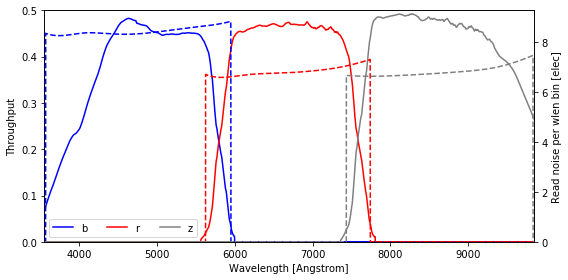

In [41]:
def plot_instrument(T=T, N=N):
    fig, lhs = plt.subplots(figsize=(8, 4))
    colors = ('b', 'r', 'gray')
    rhs = plt.twinx()
    for k, camera in enumerate(cameras):
        lhs.plot(wlen, T[:, k], c=colors[k], label=camera)
        rhs.plot(wlen, N[:, k], c=colors[k], ls='--')
    #plt.plot([], [], 'k--', label='Read noise')
    lhs.legend(ncol=3, loc='lower left')
    lhs.set_xlim(wlen[0], wlen[-1])
    lhs.set_xlabel('Wavelength [Angstrom]')
    lhs.set_ylabel('Throughput')
    rhs.set_ylabel('Read noise per wlen bin [elec]')
    lhs.set_ylim(0, 0.5)
    rhs.set_ylim(0, None)
    plt.tight_layout()
    plt.savefig('instrument.png')
    
plot_instrument()

In [42]:
!open .

### Sky Background and Extinction

Specify the typical etendue of a science fiber:

In [17]:
M1_eff_area = 8.67871 * u.m ** 2
fiber_solid_angle = 1.81165 * u.arcsec ** 2 # field average using ECHO22 platescales
fiber_etendue = M1_eff_area * fiber_solid_angle
print('Typical fiber etendue = {0:.2f}'.format(fiber_etendue))

Typical fiber etendue = 15.72 arcsec2 m2


Use the ESO model to characterize the range of sky spectra expected:

In [18]:
eso_cache = '/Users/david/Cosmo/DESI/skycalc_cache'

In [19]:
darkparams = dict(
    airmass=1,
    moon_sun_sep=150,
    moon_target_sep=150,
    moon_alt=-60,
    ecl_lon=180,
    ecl_lat=60,
    season=0,
    time=0,
    pwv=3.5,
    vacair='vac',
    wmin=355.,
    wmax=985.,
    wdelta=0.1, # 0.1nm = 1A
    observatory='2640', #paranal
)

In [20]:
darksky = skysim.eso.get_skycalc(darkparams, cache_path=eso_cache)

In [21]:
def airmass(zenith_angle):
    cosz = np.cos(np.radians(zenith_angle))
    return (cosz + 0.025 * np.exp(-11 * cosz)) ** -1

In [22]:
def moon_sun_sep(illuminated_fraction):
    phi = np.arccos(2 * illuminated_fraction - 1.) / np.pi
    return 180 * (1 - phi)

In [ ]:
moon_sun_se

In [23]:
grayparams = dict(
    airmass=airmass(40),
    moon_sun_sep=moon_sun_sep(0.4),
    moon_target_sep=90,
    moon_alt=30,
    ecl_lon=-80,
    ecl_lat=0,
    season=0,
    time=0,
    pwv=3.5,
    vacair='vac',
    wmin=355.,
    wmax=985.,
    wdelta=0.1, # 0.1nm = 1A
    observatory='2640', #paranal
)

In [24]:
graysky = skysim.eso.get_skycalc(grayparams, cache_path=eso_cache)

In [25]:
brightparams = dict(
    airmass=airmass(40),
    moon_sun_sep=moon_sun_sep(0.9),
    moon_target_sep=50,
    moon_alt=75,
    ecl_lon=-80,
    ecl_lat=0,
    season=0,
    time=0,
    pwv=3.5,
    vacair='vac',
    wmin=355.,
    wmax=985.,
    wdelta=0.1, # 0.1nm = 1A
    observatory='2640', #paranal
)

In [26]:
brightsky = skysim.eso.get_skycalc(brightparams, cache_path=eso_cache)

Extract the sky emission and target extinction spectra for each sky model:

In [27]:
skymodels = collections.OrderedDict({'BRIGHT': brightsky, 'GRAY': graysky, 'DARK': darksky})
nsky = len(skymodels)

In [28]:
def get_sky(models):
    nmodel = len(models)
    S = np.empty((nmodel, nwlen))
    E = np.empty((nmodel, nwlen))
    for m, model in enumerate(models.values()):
        # Convert wavelengths from um to A.
        lam = 1e4 * model['lam'] * u.Angstrom
        # Nominal total radiance (convert from um**-1 to A**-1)
        unit = 1e-4 * u.photon / (u.s * u.m ** 2 * u.Angstrom * u.arcsec ** 2)
        radiance = model['flux'] * unit
        # Convert from radiance to phot / s per wavelength bin.
        S[m] = (radiance * fiber_etendue * np.gradient(wlen) * u.Angstrom).to('ph / s').value
        # Lookup this model's airmass.
        X = skysim.eso.get_params(model)['airmass']
        # Calculate extinction coefficients from the transmission.
        E[m] = -np.log(model['trans']) / X
    return S, E

In [29]:
S, _ = get_sky(skymodels)

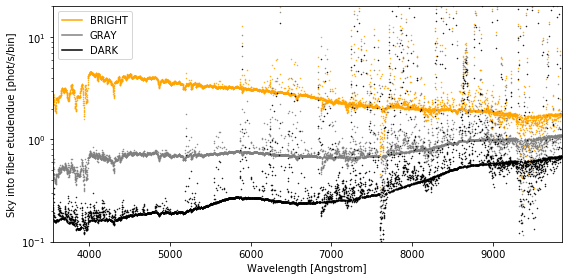

In [43]:
def plot_sky():
    fig = plt.figure(figsize=(8, 4))
    colors = ('orange', 'gray', 'k')
    for m, (label, model) in enumerate(skymodels.items()):
        plt.plot(wlen, S[m], '.', ms=1, c=colors[m])
        plt.plot([], [], '-', c=colors[m], label=label)
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Sky into fiber etudendue [phot/s/bin]')
    plt.xlim(wlen[0], wlen[-1])
    plt.ylim(0.1, 20)
    plt.tight_layout()
    plt.savefig('sky.png')
    
plot_sky()

Use the ESO sky model to sample some variation in the extinction coefficient:

In [31]:
avgparams = darkparams
avgextinct = skysim.eso.get_skycalc(avgparams, cache_path=eso_cache)

In [32]:
wetparams = dict(avgparams)
wetparams['pwv'] = 20.0
wetextinct = skysim.eso.get_skycalc(wetparams, cache_path=eso_cache)

In [33]:
dryparams = dict(avgparams)
dryparams['pwv'] = 0.5
dryextinct = skysim.eso.get_skycalc(dryparams, cache_path=eso_cache)

In [34]:
extmodels = collections.OrderedDict({'WET': wetextinct, 'AVG': avgextinct, 'DRY': dryextinct})
next = len(extmodels)

In [35]:
_, E = get_sky(extmodels)

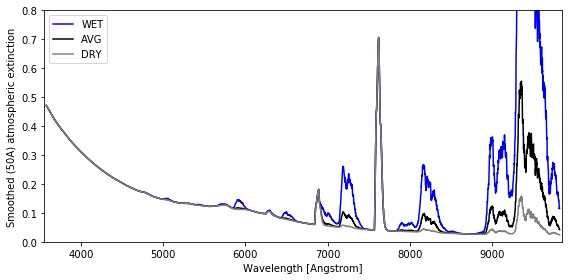

In [36]:
def plot_extinction(smoothing=50):
    fig = plt.figure(figsize=(8, 4))
    colors = ('b', 'k', 'gray')
    K = np.ones(smoothing) / smoothing
    wlen_trimmed = scipy.signal.convolve(wlen, K, mode='valid')
    for m, (label, model) in enumerate(extmodels.items()):
        Esmooth = scipy.signal.convolve(E[m], K, mode='valid')
        plt.plot(wlen_trimmed, Esmooth, '-', c=colors[m], label=label)
    plt.legend()
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Smoothed ({0:.0f}A) atmospheric extinction'.format(smoothing))
    plt.xlim(wlen[0], wlen[-1])
    plt.ylim(0, 0.8)
    plt.tight_layout()

plot_extinction()

### Combined Instrument and Sky

In [37]:
def instrument_sky(dt):
    denom = N ** 2 + dt * T * S.reshape(nsky,  nwlen, 1)
    ratio = np.divide(T ** 2, denom, out=np.zeros((nsky, nwlen, ncamera)), where=denom > 0)
    return ratio.sum(axis=-1)

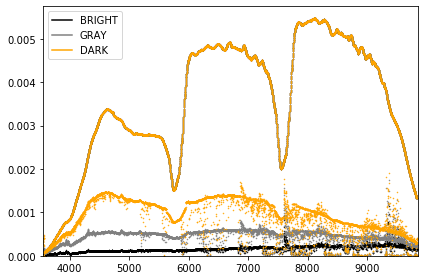

In [40]:
def plot_instrument_sky(dtvec = (0., 1000.)):
    nt = len(dtvec)
    IS = np.empty((nsky, nwlen, nt))
    colors = ('k', 'gray', 'orange')
    for i, dt in enumerate(dtvec):
        IS[:, :, i] = instrument_sky(dt)
    for m, (label, model) in enumerate(skymodels.items()):
        plt.plot(wlen, IS[m], '.', ms=1, c=colors[m])
        plt.plot([], [], '-', c=colors[m], label=label)
    plt.legend()
    plt.xlim(wlen[0], wlen[-1])
    plt.ylim(0, None)
    plt.tight_layout()
    
plot_instrument_sky()

### Fiber Acceptance Fraction

The fiber acceptance fraction $A_{ij}$ is a smooth function of wavelength and depends on the size of the PSF and any centroid offset due to guiding:

In [39]:
FFA = specsim.fastfiberacceptance.FastFiberAcceptance(
    str(DESIMODEL / 'throughput' / 'galsim-fiber-acceptance.fits'))

In [40]:
def get_fiberloss(fwhm_arcsec, offset_arcsec, fracs, hlrs, platescale=68):
    # Convert from FWHM arcsec to RMS microns at 7800A.
    rms_microns = fwhm_arcsec / 2.355 * platescale
    # Calculate the wavelength dependence of the seeing.
    rms_microns = rms_microns * (wlen / 7800) ** -0.2
    # Convert offset from arcsec to microns.
    offset_microns = np.full(nwlen, offset_arcsec) * platescale
    A = np.zeros(nwlen)
    fracs = np.asarray(fracs)
    fracs /= fracs.sum()
    for k, source in enumerate(('POINT', 'DISK', 'BULGE')):
        if fracs[k] > 0:
            A += fracs[k] * FFA.value(source, rms_microns, offset_microns, np.full(nwlen, hlrs[k]))
    return A

In [41]:
flossmodels = collections.OrderedDict(
    QSO=get_fiberloss(1.1, 0.1, [1., 0., 0.], [0, 0, 0]),
    ELG=get_fiberloss(1.1, 0.1, [0., 1., 0.], [0, 0.45, 0]),
    LRG=get_fiberloss(1.1, 0.1, [0., 0., 1.], [0, 0, 0.80]))

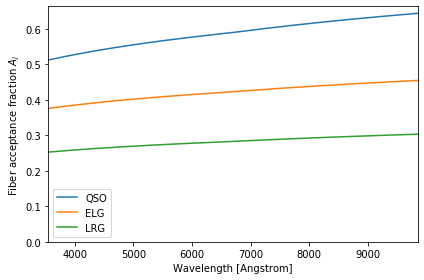

In [42]:
def plot_floss():
    for name, T in flossmodels.items():
        plt.plot(wlen, T, label=name)
    plt.legend()
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Fiber acceptance fraction $A_j$')
    plt.xlim(wlen[0], wlen[-1])
    plt.ylim(0, None)
    plt.tight_layout()
    
plot_floss()

### Dust Extinction

In [45]:
import desimodel.io

In [60]:
tiles = desimodel.io.load_tiles(onlydesi=True, extra=False)
EBV = tiles['EBV_MED']

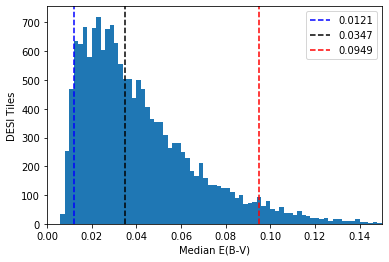

In [66]:
plt.hist(EBV, bins=np.linspace(0, 0.15, 76))
colors = ('b', 'k', 'r')
ebv_cut = np.percentile(EBV, (5, 50, 95))
for color, cut in zip(colors, ebv_cut):
    plt.axvline(cut, c=color, ls='--', label='{0:.4f}'.format(cut))
plt.legend()
plt.xlabel('Median E(B-V)')
plt.ylabel('DESI Tiles')
plt.xlim(0, 0.15);

In [63]:
RV = 3.1
AV = ebv_cut * RV
dustmodels = collections.OrderedDict(
    LOW=extinction.apply(extinction.fm07(wlen, AV[0]), np.ones_like(wlen)),
    MED=extinction.apply(extinction.fm07(wlen, AV[1]), np.ones_like(wlen)),
    HIGH=extinction.apply(extinction.fm07(wlen, AV[2]), np.ones_like(wlen)),
)

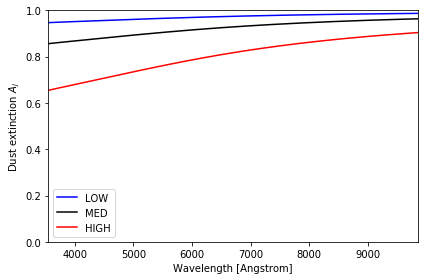

In [67]:
def plot_dust():
    colors = ('b', 'k', 'r')
    for color, (name, D) in zip(colors, dustmodels.items()):
        plt.plot(wlen, D, c=color, label=name)
    plt.legend()
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Dust extinction $A_j$')
    plt.xlim(wlen[0], wlen[-1])
    plt.ylim(0, 1)
    plt.tight_layout()

plot_dust()

## API Development

In [4]:
def get_target_sensitivity(target):
    """Get the tabulated sensitivity <dF**2> for the named target class.

    Sensitivity is defined as the ensemble average of F[i] - Fmed[i]
    over a representative sample of targets in the class, where
    F[i] is the expected number of photons entering a fiber per second,
    as a function of wavelength, and Fmed[i] is the result of applying
    a 100A median filter to F[i].

    Returns a cached value if this target class has already been loaded.

    Parameters
    ----------
    target : str
        One of the target class names predefined in desimodel.

    Returns
    -------
    tuple
        Tuple (wlen, dF2) of 1D arrays of the same length, with tabulated
        wavelengths in Angstrom and corresponding <dF**2> values.
    """
    wlen = 0.1 * np.arange(35500, 98501)
    
    # Use new code in desimodel.io here...
    dF2 = np.ones_like(wlen)
    
    return wlen, dF2

In [5]:
def get_instrument_sky_snr2(texp, throughput, readvar, skyflux):
    """Calculate the contribution to zSNR2 from throughput, read noise and sky.
    
    Input arrays must all be tabulated on the same wavlength grid,
    returned by :meth:`get_target_sensitivity`.
    
    Parameters
    ----------
    texp : float
        Exposure time in seconds.
    throughput : array
        2D array of shape (3, NW) of throughput values, excluding fiberloss,
        indexed by camera band (in the order b,r,z) and wavelength bin.
    readvar : array
        2D array of shape (3, NW) of read variances in electron ** 2 per wavelength bin,
        indexed by camera band (in the order b,r,z) and wavelength bin.
    skyflux : array
        1D array of shape (NW,) of sky fluxes defined as photons entering a
        fiber per second.
        
    Returns
    -------
    array
        1D array of length NW of tabulated values of T ** 2 / (rdvar + t T * S)
        summed over each camera band.
    """
    # When throughput is zero, the result is zero.
    ratio = np.divide(
        throughput ** 2, readvar + texp * throughput * skyflux,
        out=np.zeros_like(throughput), where=throughput > 0)
    return np.sum(ratio, axis=0)

In [6]:
def get_zSNR2(texp, target, throughput, readvar, skyflux, fiberloss, fdust=1, fatm=1):
    """Calcualte the zSNR2 metric of tile completion.
    
    See DESI-4723 for details.
    
    Input arrays must all be tabulated on the same wavlength grid,
    returned by :meth:`get_target_sensitivity`.
    
    Parameters
    ----------
    texp : float
        Exposure time in seconds.
    target : str
        One of the target class names predefined in desimodel.
    throughput : array
        2D array of shape (3, NW) of throughput values, excluding fiberloss,
        indexed by camera band (in the order b,r,z) and wavelength bin.
    readvar : array
        2D array of shape (3, NW) of read variances in electron ** 2 per wavelength bin,
        indexed by camera band (in the order b,r,z) and wavelength bin.
    skyflux : array
        1D array of shape (NW,) of sky fluxes defined as photons entering a
        fiber per second.
    fiberloss : array
        1D array of shape (NW,) of fiber acceptance fractions for the specified
        target class.
    fdust : float or array
        Dust extinction to apply. Can be a constant value or tabulated vs wavelength.
    fatm : float or array
        Atmospheric extinction to apply. Can be a constant value or tabulated vs wavelength.
        
    Returns
    -------
    float
        The value of zSNR2.
    """
    wlen, dF2 = get_target_sensitivity(target)
    ins_sky = get_instrument_sky_snr2(texp, throughput, readvar, skyflux)
    return texp ** 2 * np.sum((fdust * fatm * fiberloss) ** 2 * dF2 * ins_sky)

## Test with Specsim

In [3]:
import specsim.simulator
desisim = specsim.simulator.Simulator('desi', num_fibers=1)
desisim.simulate()

The nominal wavelength grid matches the one used internally by specsim:

In [7]:
wlen, dF2 = get_target_sensitivity('QSO')
np.allclose(wlen, desisim.simulated['wavelength'])

True

Extract the specsim throughput, read-noise variance, and sky flux:

In [8]:
throughput = np.stack([C.throughput for C in desisim.instrument.cameras])
readvar = np.stack([C.read_noise_per_bin.to('electron').value ** 2 for C in desisim.instrument.cameras])
skyflux = (
    desisim.atmosphere.surface_brightness *
    desisim.instrument.photons_per_bin *
    desisim.fiber_area).to('1/s').value

In [9]:
throughput.shape

(3, 63001)

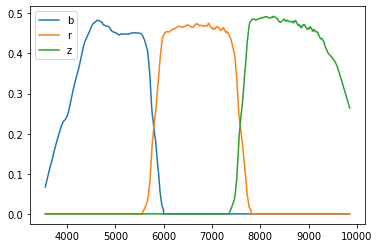

In [11]:
plt.plot(wlen, throughput[0], label='b')
plt.plot(wlen, throughput[1], label='r')
plt.plot(wlen, throughput[2], label='z')
plt.legend()

Calculate the instrument and sky contribution to zSNR2 for a 1000s exposure:

In [9]:
texp = 1000.
ins_sky = get_instrument_sky_snr2(texp, throughput, readvar, skyflux)

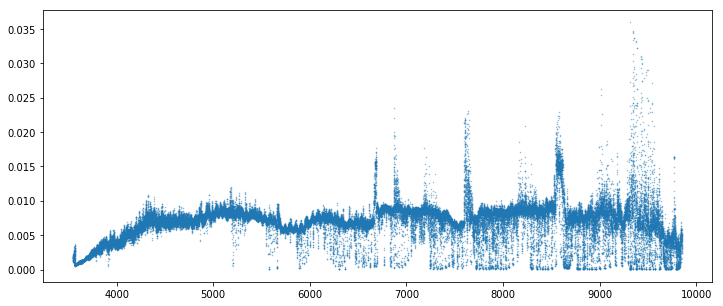

In [10]:
fig = plt.figure(figsize=(12, 5))
plt.plot(wlen, ins_sky, '.', ms=1, alpha=0.5);

Extract the specsim fiberloss:

In [11]:
fibernum = 0
fiberloss = np.array(desisim.simulated['fiberloss'])[fibernum]

Calculate zSNR2 (ignore the value since we are using dF2 = 1):

In [12]:
get_zSNR2(texp, 'QSO', throughput, readvar, skyflux, fiberloss)

96334156.47848043

## Open Issues

API above assumes that a standardized wavelength grid is used consistently for throughput, etc.  For example,
the specsim internal grid:

In [13]:
wlen

array([3550. , 3550.1, 3550.2, ..., 9849.8, 9849.9, 9850. ])

Is this sufficient or do we need more flexibility? (with additional validation and support for resampling)

We treat $\langle\delta F^2\rangle_{C,\lambda}$ as independent of the camera, but this is not strictly correct because they have different resolutions. We can finesse this using some average resolution, or just do it correctly.

Text(0, 0.5, 'FWHM Resolution [A]')

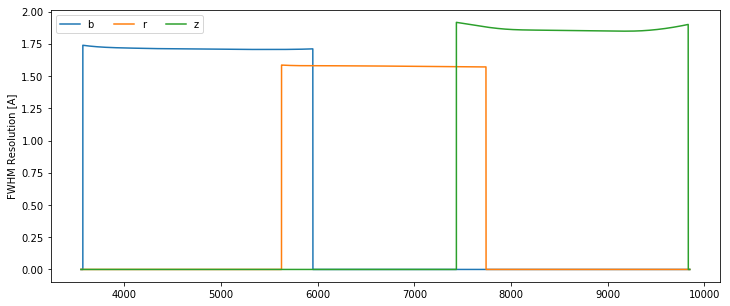

In [14]:
fig = plt.figure(figsize=(12, 5))
for camera in desisim.instrument.cameras:
    plt.plot(wlen, camera._fwhm_resolution, label=camera.name)
plt.legend(ncol=3)
plt.ylabel('FWHM Resolution [A]')

The ETC measures the fiberloss of a point source (using GFA stars), but this is not the same as the fiberloss $A_{C,\lambda}$ above for extended sources.

If we assume a nominal size galaxy size for each target class, the correction is straightforward.  However, since galaxy size is correlated with redshift, doing this correctly changes the weights of the ensemble average in $\langle\delta F^2\rangle$.

A good compromise is to tabulate $\langle\delta F^2\rangle_{C,\lambda}$ for a few different simulated seeing values, for each target class $C$, then interpolate to the ETC measured seeing.